In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np   # for image array
import pandas as pd
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential   # for NN
from tensorflow.keras.preprocessing.image import load_img   , img_to_array     # for image load
from tensorflow.keras.applications import VGG16    # transfer learnig
from tensorflow.keras.optimizers import Adam   # to reduce learning rate
from tensorflow.keras.layers import  Input, Flatten , Dropout , BatchNormalization , Dense, MaxPool2D , Conv2D
from sklearn.utils import shuffle


### Load and Shuffle data

In [ ]:

train_dir = '/content/drive/MyDrive/MRI DATASET/Training/'
test_dir = '/content/drive/MyDrive/MRI DATASET/Testing/'

In [ ]:
import os
image_folder = "/content/drive/MyDrive/MRI DATASET/Training/"
images = os.listdir(image_folder)

print(images[:5])  # Show first 5 image names

['pituitary', 'glioma', 'meningioma', 'notumor']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

image_data = datagen.flow_from_directory(
    "/content/drive/MyDrive/MRI DATASET/Testing/",
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='categorical'  # Use 'binary' for 2 classes
)


Found 1311 images belonging to 4 classes.


In [ ]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/MRI DATASET/Training/'
test_dir = '/content/drive/MyDrive/MRI DATASET/Testing/'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
  #print(label)
    for image in os.listdir(os.path.join(train_dir, label)):
      #print(image)
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [ ]:
test_paths

['/content/drive/MyDrive/MRI DATASET/Testing/pituitary/Te-pi_0094.jpg',
 '/content/drive/MyDrive/MRI DATASET/Testing/notumor/Te-no_0303.jpg',
 '/content/drive/MyDrive/MRI DATASET/Testing/notumor/Te-no_0299.jpg',
 '/content/drive/MyDrive/MRI DATASET/Testing/meningioma/Te-me_0136.jpg',
 '/content/drive/MyDrive/MRI DATASET/Testing/meningioma/Te-me_0039.jpg',
 '/content/drive/MyDrive/MRI DATASET/Testing/pituitary/Te-pi_0178.jpg',
 '/content/drive/MyDrive/MRI DATASET/Testing/glioma/Te-gl_0151.jpg',
 '/content/drive/MyDrive/MRI DATASET/Testing/notumor/Te-no_0044.jpg',
 '/content/drive/MyDrive/MRI DATASET/Testing/meningioma/Te-me_0232.jpg',
 '/content/drive/MyDrive/MRI DATASET/Testing/notumor/Te-no_0148.jpg',
 '/content/drive/MyDrive/MRI DATASET/Testing/meningioma/Te-me_0090.jpg',
 '/content/drive/MyDrive/MRI DATASET/Testing/pituitary/Te-pi_0060.jpg',
 '/content/drive/MyDrive/MRI DATASET/Testing/meningioma/Te-me_0204.jpg',
 '/content/drive/MyDrive/MRI DATASET/Testing/meningioma/Te-me_0267.jpg

### Data Visualization

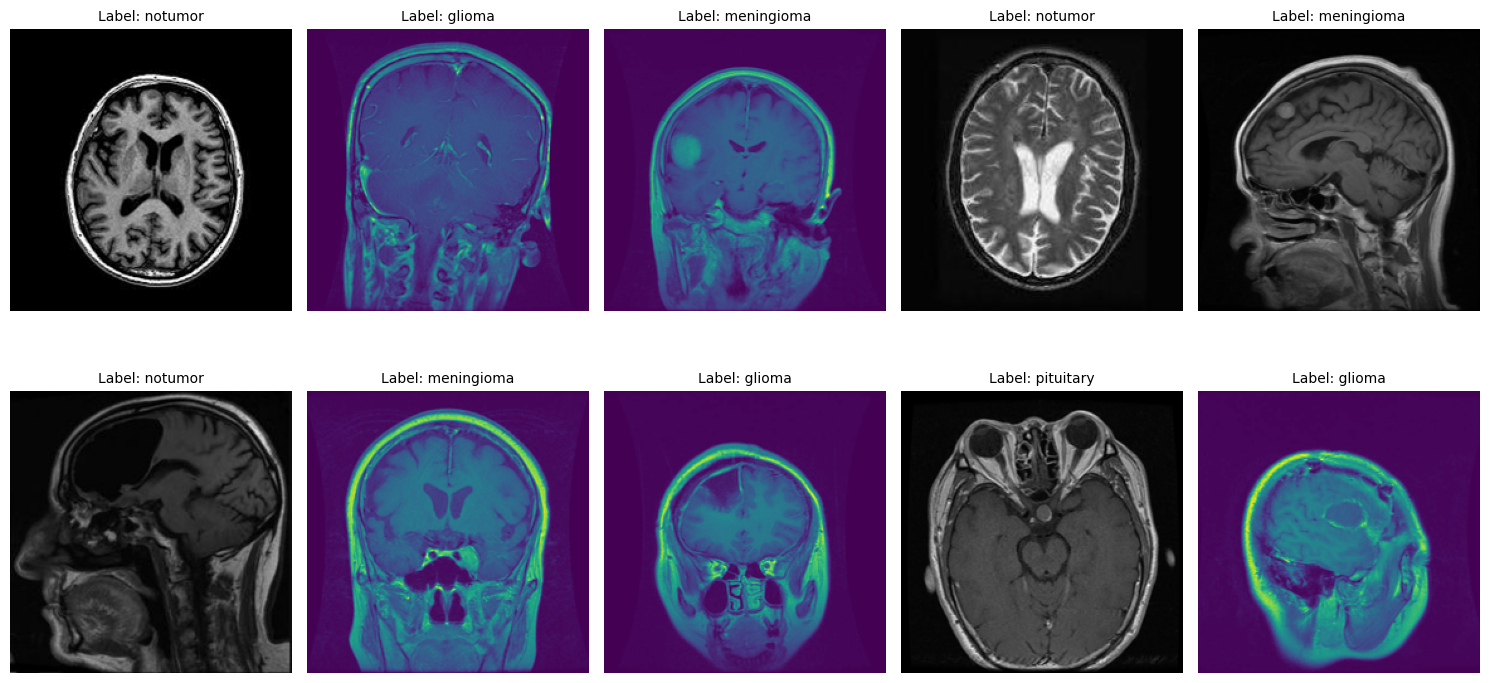

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

### Image Preprocessing

In [ ]:

# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [ ]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1406s 5s/step - loss: 0.6778 - sparse_categorical_accuracy: 0.7284
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1399s 5s/step - loss: 0.2366 - sparse_categorical_accuracy: 0.9081
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1431s 5s/step - loss: 0.1622 - sparse_categorical_accuracy: 0.9413
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1422s 5s/step - loss: 0.1176 - sparse_categorical_accuracy: 0.9568
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1423s 5s/step - loss: 0.0918 - sparse_categorical_accuracy: 0.9668


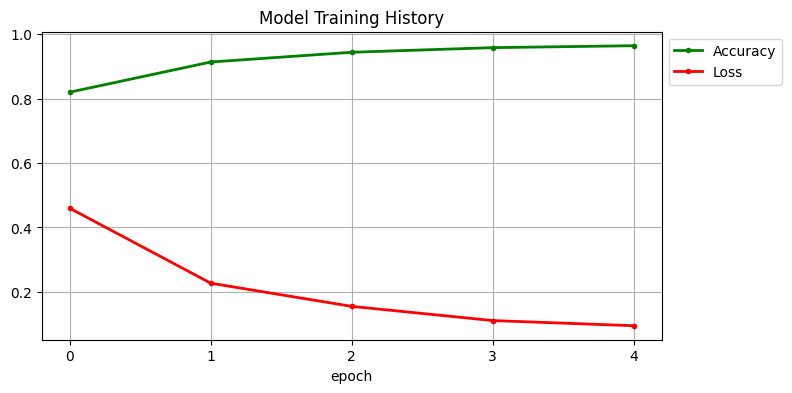

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Model Evalutaion

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 269s 7s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       300
           1       0.97      0.87      0.92       300
           2       0.87      0.97      0.92       306
           3       1.00      0.99      0.99       405

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



### Confusion Matrix

In [ ]:
conf = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print(conf)

[[296   0   4   0]
 [  1 260  39   0]
 [  3   5 298   0]
 [  0   3   3 399]]


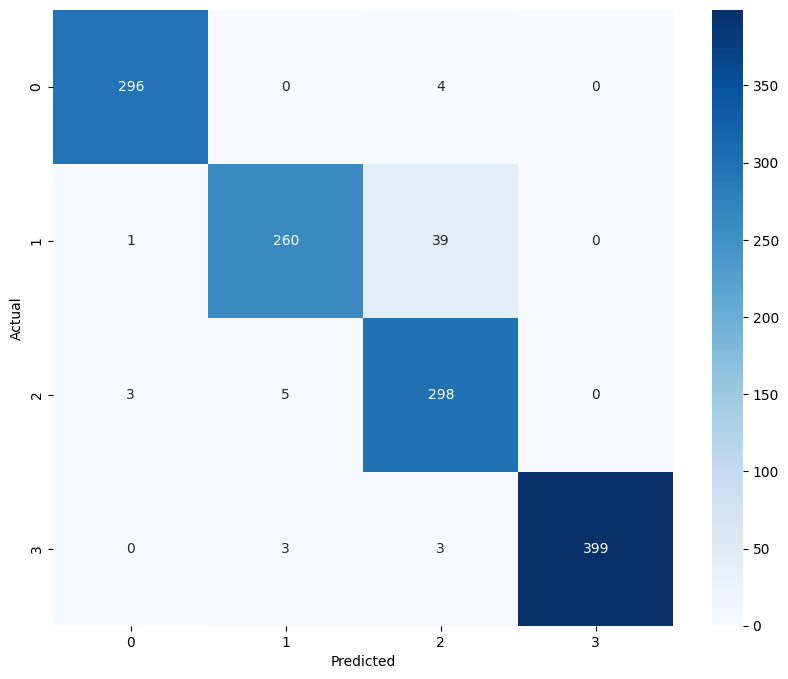

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf, annot=True , fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()